## Load segmented affix occurrences from supplement

In [1]:
import functools
import hashlib
import io
import pathlib
import shutil
import urllib.request
import zipfile

URL = 'https://zenodo.org/record/841982/files/xflr6/portmanteaus-v1.0.zip'

CSV = pathlib.Path('esm3-analyses.csv')


def sha256sum(filename, bufsize=32768):
    s = hashlib.sha256()
    with io.open(filename, 'rb') as fd:
        for data in iter(functools.partial(fd.read, bufsize), b''):
            s.update(data)
    return s.hexdigest()


if not CSV.exists():
    with io.BytesIO() as b:
        with urllib.request.urlopen(URL) as u:
            shutil.copyfileobj(u, b)
        with zipfile.ZipFile(b) as z:
            i, = (i for i in z.infolist() if i.filename.endswith(CSV.name))
            i.filename = CSV.name
            z.extract(i)

sha256sum(CSV)

'6e6389a913cc01020d03ac16217bc1c63c9d0e16b78179b4c931741c0d5a69cf'

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats


def pearsonr(df, left, right, func=scipy.stats.pearsonr):
    df = df[[left, right]].dropna()
    name = f'{left} & {right}'
    with np.errstate(invalid='ignore'):
        result = func(df[left], df[right])
    return pd.Series(result, index=('r', 'p'), name=name)


plt.style.use('classic')
plt.rcParams.update({'figure.figsize': (6, 4), 'figure.facecolor': 'w',
                     'figure.subplot.bottom': .125, 'font.size': 10, 'savefig.dpi': 72})


In [3]:
RENAME = {'Quechua (Ayacucho)': 'Ayacucho', 'Tlachichilco Tepehuan': 'Tepehua', 'Lakhota': 'Lakota'}


cf = pd.read_csv(CSV, encoding='utf-8')

cf['Language'] = cf['Language'].replace(RENAME)
cf = cf.sort_values(by='Language', kind='mergesort').reset_index(drop=True)

cf.info()
assert cf.set_index(['Language', 'Cell', 'Position']).index.is_unique
cf.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2818 entries, 0 to 2817
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Language  2818 non-null   object
 1   Cell      2818 non-null   object
 2   Position  2818 non-null   int64 
 3   Form      2818 non-null   object
 4   Meaning   2818 non-null   object
dtypes: int64(1), object(4)
memory usage: 110.2+ KB


,Language,Cell,Position,Form,Meaning
0,Ainu,1s,-1,ku,SA[+1 +sg]
1,Ainu,1p,1,as,S[+1 +pl]
2,Ainu,2s,-1,e,SAP[-3 +sg]
3,Ainu,2p,-1,eci,SAP[+2]
4,Ainu,x,1,an,S[-1 -2 -3]
5,Ainu,1s->2s,-1,eci,SAP[+2]
6,Ainu,1s->2p,-1,eci,SAP[+2]
7,Ainu,1s->3s,-1,ku,SA[+1 +sg]
8,Ainu,1s->3p,-1,ku,SA[+1 +sg]
9,Ainu,1s->x,-2,ku,SA[+1 +sg]


## Reconcatenate word-forms with stem symbol

In [4]:
STEM = 'Σ'


assert not cf['Form'].str.contains(STEM).any()

_cf = (cf.drop('Meaning', axis=1)
       .assign(cell_index=lambda x: x.groupby(['Language', 'Cell'], sort=False).ngroup()))

_sf = (_cf.drop_duplicates('cell_index')
       .assign(Position=0, Form=STEM))

df = (pd.concat([_cf, _sf])
      .sort_values(by=['cell_index', 'Position'])
      .groupby(['cell_index', 'Language', 'Cell'])[['Form']]
      .agg(''.join)
      .reset_index('cell_index', drop=True))

df.info()
assert df.index.is_unique
df.head(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1317 entries, ('Ainu', '1s') to ('Yimas', '3p->3p')
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Form    1317 non-null   object
dtypes: object(1)
memory usage: 17.3+ KB


Form
Language Cell        
Ainu     1s       kuΣ
         1p       Σas
         2s        eΣ
         2p      eciΣ
         x        Σan
         1s->2s  eciΣ
         1s->2p  eciΣ
         1s->3s   kuΣ
         1s->3p   kuΣ
         1s->x   kuiΣ

## Tag cells as 1/2&lt;-&gt;1/2, 1/2&lt;-&gt;3, and other

In [5]:
SEP = '->'


def is_distinct_local(cellkey, sep=SEP, persons=('1', '2')):
    subj, trans, obj = cellkey.partition(sep)
    local_subj, local_obj = (any(p in arg for p in persons) for arg in (subj, obj))
    if local_subj and local_obj:
        return True
    elif trans and (local_subj or local_obj):
        return False
    else:
        return None


df.insert(0, 'd_local', df.index.get_level_values('Cell').map(is_distinct_local))

df.info()
assert df.index.is_unique
df.head(30)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1317 entries, ('Ainu', '1s') to ('Yimas', '3p->3p')
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   d_local  912 non-null    object
 1   Form     1317 non-null   object
dtypes: object(2)
memory usage: 59.9+ KB


d_local    Form
Language Cell                  
Ainu     1s        None     kuΣ
         1p        None     Σas
         2s        None      eΣ
         2p        None    eciΣ
         x         None     Σan
         1s->2s    True    eciΣ
         1s->2p    True    eciΣ
         1s->3s   False     kuΣ
         1s->3p   False     kuΣ
         1s->x    False    kuiΣ
         1p->2s    True    eciΣ
         1p->2p    True    eciΣ
         1p->3s   False     ciΣ
         1p->3p   False     ciΣ
         1p->x    False     aiΣ
         2s->1s    True     enΣ
         2s->1p    True     unΣ
         2s->3s   False      eΣ
         2s->3p   False      eΣ
         2s->x    False     eiΣ
         2p->1s    True  ecienΣ
         2p->1p    True  eciunΣ
         2p->3s   False    eciΣ
         2p->3p   False    eciΣ
         2p->x    False   eciiΣ
         3s->1s   False     enΣ
         3s->1p   False     unΣ
         3s->2s   False      eΣ
         3s->2p   False    eciΣ
         3s->x     None      iΣ

## Neutralization ratios (1/2&lt;-&gt;3 vs. 1/2&lt;-&gt;1/2)

In [6]:
xf = (df.dropna(subset=['d_local'])
      .groupby(['Language', 'd_local'])['Form']
      .agg(['size', 'nunique']))

xf['neut'] = xf['size'] - xf['nunique']
xf['ratio'] = 100 * xf['neut'] / (xf['size'] - 1)
xf['ratio (norm)'] = xf['ratio'] / xf['ratio'].groupby(level='Language').sum()
xf.loc[xf['ratio (norm)'].isnull(), 'ratio'] = None

xfp = xf.reset_index('d_local')
xf = xf.unstack()

xf

size       nunique        neut            ratio             \
d_local     False True    False True  False True       False      True    
Language                                                                  
Ainu           24     8      14     5    10     3  43.478261  42.857143   
Aleut          36    18      13     5    23    13  65.714286  76.470588   
Ayacucho       20     8      11     6     9     2  47.368421  28.571429   
Bella Coola    16     8      13     6     3     2  20.000000  28.571429   
Chuckchi       15     8       7     6     8     2  57.142857  28.571429   
Darai          16     8      11     5     5     3  33.333333  42.857143   
Fox            20     8      16     6     4     2  21.052632  28.571429   
Hixkaryana     18     6       7     3    11     3  64.705882  60.000000   
Jaqaru          6     3       5     3     1     0  20.000000   0.000000   
Jumjum         24     8      17     8     7     0  30.434783   0.000000   
Karuk          16     8       9     5     7     3  46.666667  42.857143   
Ket            48     8      22     8    26     0  55.319149   0.000000   
Kunama         48    18      22     7    26    11  55.319149  64.705882   
Lakota         20     8      13     6     7     2  36.842105  28.571429   
Maricopa       16     8       3     2    13     6  86.666667  85.714286   
Maung          60     8      45     4    15     4  25.423729  57.142857   
Mordvin        16     8      10     4     6     4  40.000000  57.142857   
Nocte          16     8       6     3    10     5  66.666667  71.428571   
Reyesano       16     8       8     2     8     6  53.333333  85.714286   
Sahu           60     8      30     8    30     0  50.847458   0.000000   
Siuslawan      48    18      48    17     0     1   0.000000   5.882353   
Tepehua        20     8      15     4     5     4  26.315789  57.142857   
Thangmi        16     8      10     6     6     2  40.000000  28.571429   
Turkana        16     8       7     3     9     5  60.000000  71.428571   
Wardaman       24     8      23     7     1     1   4.347826  14.285714   
Yimas          36    18      30    17     6     1  17.142857   5.882353   

            ratio (norm)            
d_local            False     True   
Language                            
Ainu            0.503597  0.496403  
Aleut           0.462175  0.537825  
Ayacucho        0.623762  0.376238  
Bella Coola     0.411765  0.588235  
Chuckchi        0.666667  0.333333  
Darai           0.437500  0.562500  
Fox             0.424242  0.575758  
Hixkaryana      0.518868  0.481132  
Jaqaru          1.000000  0.000000  
Jumjum          1.000000  0.000000  
Karuk           0.521277  0.478723  
Ket             1.000000  0.000000  
Kunama          0.460897  0.539103  
Lakota          0.563218  0.436782  
Maricopa        0.502762  0.497238  
Maung           0.307918  0.692082  
Mordvin         0.411765  0.588235  
Nocte           0.482759  0.517241  
Reyesano        0.383562  0.616438  
Sahu            1.000000  0.000000  
Siuslawan       0.000000  1.000000  
Tepehua         0.315315  0.684685  
Thangmi         0.583333  0.416667  
Turkana         0.456522  0.543478  
Wardaman        0.233333  0.766667  
Yimas           0.744526  0.255474

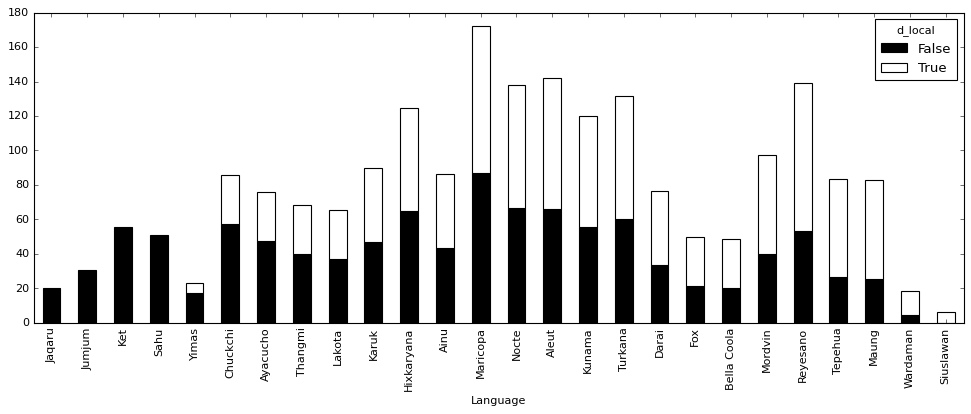

In [7]:
(xf.sort_values(by=('ratio (norm)', True), kind='mergesort')['ratio']
 .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray));

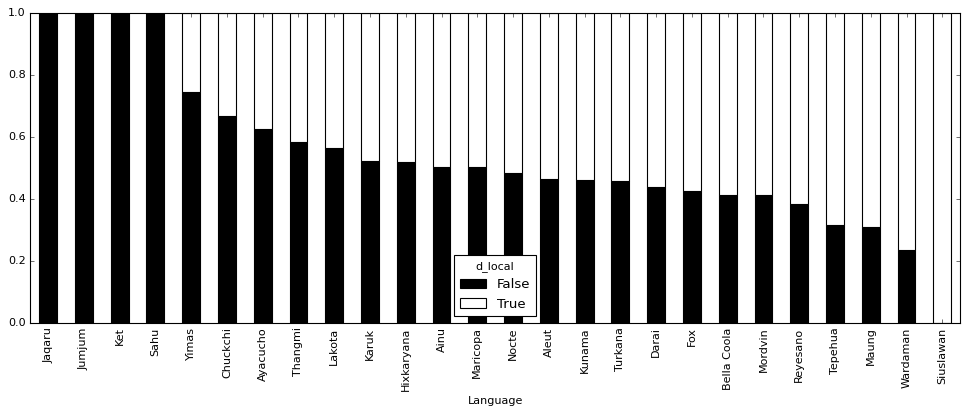

In [8]:
(xf['ratio (norm)'].sort_values(by=True, kind='mergesort')
 .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray));

## Test for neutralization differences

In [9]:
pd.DataFrame([pearsonr(xfp, 'd_local', c) for c in ['ratio', 'ratio (norm)']])

,r,p
d_local & ratio,-0.043886,0.757379
d_local & ratio (norm),-0.159971,0.257281


## Count 1/2 subcategory (number, gender) neutralizations

In [10]:
ff = df.dropna(subset=['d_local']).reset_index()
ff[['A', 'P']] = ff['Cell'].str.partition(SEP)[[0, 2]]
print(pd.concat([ff['A'], ff['P']]).unique())

a_first, p_first = (ff[x].str.contains(r'1') for x in ('A', 'P'))
a_second, p_second = (ff[x].str.contains(r'2|[dp]i') for x in ('A', 'P'))
a_third, p_third = ~a_first & ~a_second, ~p_first & ~p_second

# treat inclusive cells as first person only
a_second &= ~a_first; p_second &= ~p_first
assert (pd.concat([a_first, a_second, a_third], axis=1).sum(axis=1) == 1).all()
assert (pd.concat([p_first, p_second, p_third], axis=1).sum(axis=1) == 1).all()

groups = {'1->X:P': a_first & p_third,
          '2->X:P': a_second & p_third,
          'X->1:A': a_third & p_first,
          'X->2:A': a_third & p_second,
          #
          '1->2:A': a_first & p_second,
          '2->1:A': a_second & p_first,
          '1->2:P': a_first & p_second,
          '2->1:P': a_second & p_first}

lf = (pd.concat([ff[c].groupby(['Language', 'd_local', g.rpartition(':')[-1]])['Form']
                 .agg(['size', 'nunique'])
                 .assign(group=g)
                 .set_index('group', append=True)
                 .swaplevel()
                 .reset_index('d_local')
                 for g, c in groups.items()])
      .sort_index())
lf.index.rename('X', level=2, inplace=True)

lf['neut'] = lf['size'] - lf['nunique']
lf['ratio'] = 100 * lf['neut'] / (lf['size'] - 1)

lf.head(14)

['1s' '1p' '2s' '2p' '3s' '3p' 'x' '1d' '2d' '3d' '1pe' '1pi' '1' '12' '2'
 '3' '1di' '3s.m' '3s.f' '3s.n' '3p.m' '3p.f' '3p.n' '1de' '3.I' '3.III'
 '3.II' '3.IV' '3.V' '3.VI']


d_local  size  nunique  neut  ratio
Language group  X                                      
Ainu     1->2:A 1p     True     2        1     1  100.0
                1s     True     2        1     1  100.0
         1->2:P 2p     True     2        1     1  100.0
                2s     True     2        1     1  100.0
         1->X:P 3p    False     2        2     0    0.0
                3s    False     2        2     0    0.0
                x     False     2        2     0    0.0
         2->1:A 2p     True     2        2     0    0.0
                2s     True     2        2     0    0.0
         2->1:P 1p     True     2        2     0    0.0
                1s     True     2        2     0    0.0
         2->X:P 3p    False     2        2     0    0.0
                3s    False     2        2     0    0.0
                x     False     2        2     0    0.0

## 1/2 subcategory neutralization ratios (1/2&lt;-&gt;3 vs. 1/2&lt;-&gt;1/2)

In [11]:
rf = lf.pivot_table('ratio', ['Language', 'd_local'], aggfunc='mean')

rf['ratio (norm)'] = rf['ratio'] /  rf['ratio'].groupby(level='Language').sum()
rf.loc[rf['ratio (norm)'].isnull(), 'ratio'] = None

rfp = rf.reset_index('d_local')
rf = rf.unstack()

rf

ratio             ratio (norm)          
d_local           False       True         False     True 
Language                                                  
Ainu           0.000000   50.000000     0.000000  1.000000
Aleut         62.500000   62.500000     0.500000  0.500000
Ayacucho       6.250000   25.000000     0.200000  0.800000
Bella Coola    0.000000   12.500000     0.000000  1.000000
Chuckchi      28.571429   25.000000     0.533333  0.466667
Darai         25.000000   37.500000     0.400000  0.600000
Fox           12.500000   25.000000     0.333333  0.666667
Hixkaryana    50.000000   60.000000     0.454545  0.545455
Jaqaru              NaN         NaN          NaN       NaN
Jumjum              NaN         NaN          NaN       NaN
Karuk          0.000000   37.500000     0.000000  1.000000
Ket                 NaN         NaN          NaN       NaN
Kunama        31.250000   54.166667     0.365854  0.634146
Lakota        31.250000   25.000000     0.555556  0.444444
Maricopa     100.000000  100.000000     0.500000  0.500000
Maung          0.000000   50.000000     0.000000  1.000000
Mordvin       25.000000   50.000000     0.333333  0.666667
Nocte         50.000000   75.000000     0.400000  0.600000
Reyesano       0.000000   50.000000     0.000000  1.000000
Sahu                NaN         NaN          NaN       NaN
Siuslawan           NaN         NaN          NaN       NaN
Tepehua       25.000000   50.000000     0.333333  0.666667
Thangmi        0.000000   25.000000     0.000000  1.000000
Turkana       25.000000   50.000000     0.333333  0.666667
Wardaman       0.000000   12.500000     0.000000  1.000000
Yimas          0.000000    4.166667     0.000000  1.000000

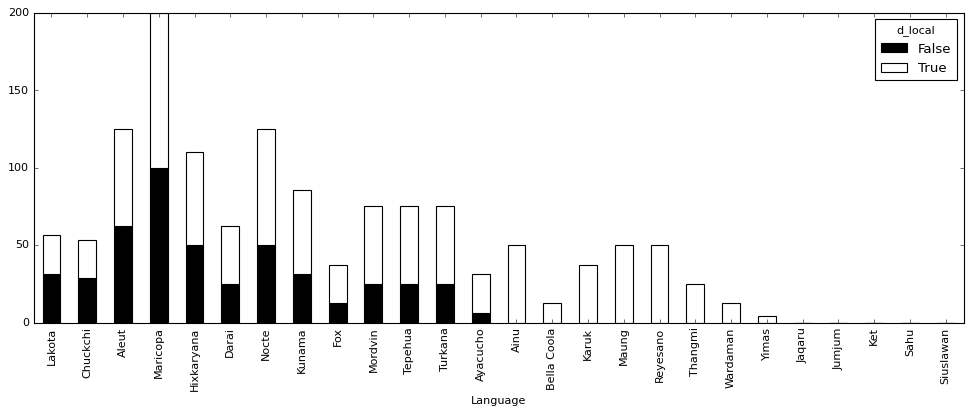

In [12]:
(rf.sort_values(by=('ratio (norm)', True), kind='mergesort')['ratio']
 .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray));

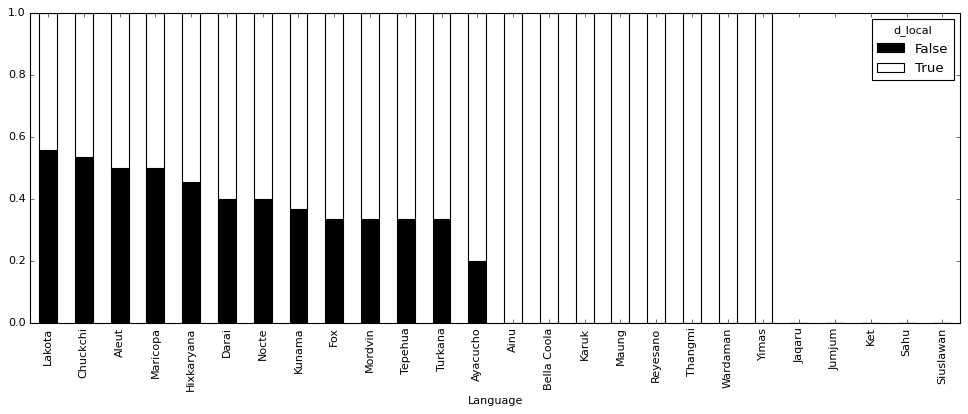

In [13]:
(rf['ratio (norm)'].sort_values(by=True, kind='mergesort')
 .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray));

## Test for 1/2 subcategory neutralization differences

In [14]:
pd.DataFrame([pearsonr(rfp, 'd_local', c) for c in ['ratio', 'ratio (norm)']])

,r,p
d_local & ratio,0.375982,1.413199e-02
d_local & ratio (norm),0.765624,3.494391e-09


## Absense of non-person features in learned meanings

In [15]:
cf['Meaning'].str.extractall(r'([+-]\w+)')[0].value_counts().to_frame('n')

,n
0,
+pl,638
+1,622
+3,618
+2,595
+sg,475
-1,437
-3,366
-2,359
-sg,243


In [16]:
NONPERSON = r'[+-]\D+\b'

nf = cf.assign(PersonOnly=lambda x: ~x['Meaning'].str.contains(NONPERSON))

nf.head(14)

,Language,Cell,Position,Form,Meaning,PersonOnly
0,Ainu,1s,-1,ku,SA[+1 +sg],False
1,Ainu,1p,1,as,S[+1 +pl],False
2,Ainu,2s,-1,e,SAP[-3 +sg],False
3,Ainu,2p,-1,eci,SAP[+2],True
4,Ainu,x,1,an,S[-1 -2 -3],True
5,Ainu,1s->2s,-1,eci,SAP[+2],True
6,Ainu,1s->2p,-1,eci,SAP[+2],True
7,Ainu,1s->3s,-1,ku,SA[+1 +sg],False
8,Ainu,1s->3p,-1,ku,SA[+1 +sg],False
9,Ainu,1s->x,-2,ku,SA[+1 +sg],False


In [17]:
cnf = (nf.groupby(['Language', 'Cell'], sort=False)['PersonOnly'].all()
       .to_frame('PersonOnly'))

cnf.insert(0, 'd_local', cnf.index.get_level_values('Cell').map(is_distinct_local))

cnf.head(14)

d_local  PersonOnly
Language Cell                      
Ainu     1s        None       False
         1p        None       False
         2s        None       False
         2p        None        True
         x         None        True
         1s->2s    True        True
         1s->2p    True        True
         1s->3s   False       False
         1s->3p   False       False
         1s->x    False       False
         1p->2s    True        True
         1p->2p    True        True
         1p->3s   False       False
         1p->3p   False       False

In [18]:
xnf = (cnf.dropna(subset=['d_local'])
       .groupby(['Language', 'd_local']).mean()
       .rename(columns={'PersonOnly': 'ratio'}))

xnf['ratio (norm)'] = xnf['ratio'] / xnf['ratio'].groupby(level='Language').sum()
xnf.loc[xnf['ratio (norm)'].isnull(), 'ratio'] = None

xnfp = xnf.reset_index('d_local')
xnf = xnf.unstack()

xnf

ratio           ratio (norm)          
d_local         False     True         False     True 
Language                                              
Ainu         0.291667  0.500000     0.368421  0.631579
Aleut        0.333333  0.000000     1.000000  0.000000
Ayacucho     0.250000  0.125000     0.666667  0.333333
Bella Coola       NaN       NaN          NaN       NaN
Chuckchi          NaN       NaN          NaN       NaN
Darai        0.125000  0.000000     1.000000  0.000000
Fox          0.000000  0.125000     0.000000  1.000000
Hixkaryana   0.777778  0.666667     0.538462  0.461538
Jaqaru       0.666667  0.000000     1.000000  0.000000
Jumjum       0.041667  0.000000     1.000000  0.000000
Karuk        0.125000  0.250000     0.333333  0.666667
Ket          0.083333  0.000000     1.000000  0.000000
Kunama       0.041667  0.000000     1.000000  0.000000
Lakota       0.200000  0.125000     0.615385  0.384615
Maricopa     1.000000  1.000000     0.500000  0.500000
Maung        0.016667  0.000000     1.000000  0.000000
Mordvin      0.437500  0.750000     0.368421  0.631579
Nocte        0.625000  0.750000     0.454545  0.545455
Reyesano     0.250000  0.500000     0.333333  0.666667
Sahu         0.266667  0.000000     1.000000  0.000000
Siuslawan    0.041667  0.000000     1.000000  0.000000
Tepehua      0.600000  0.250000     0.705882  0.294118
Thangmi      0.125000  0.000000     1.000000  0.000000
Turkana      0.437500  0.500000     0.466667  0.533333
Wardaman     0.333333  0.500000     0.400000  0.600000
Yimas             NaN       NaN          NaN       NaN

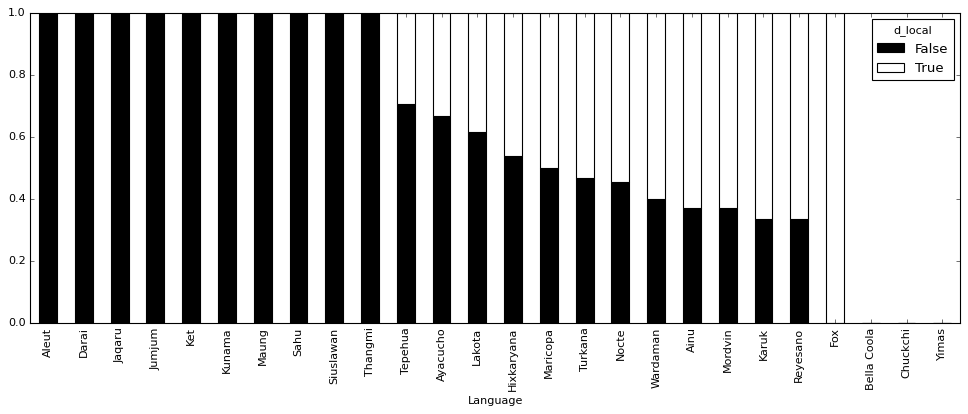

In [19]:
(xnf['ratio (norm)'].sort_values(by=True, kind='mergesort')
 .plot.bar(stacked=True, figsize=(15, 5), cmap=plt.cm.gray));

In [20]:
pd.DataFrame([pearsonr(xnfp, 'd_local', c) for c in ['ratio', 'ratio (norm)']])

,r,p
d_local & ratio,-0.077841,0.607115
d_local & ratio (norm),-0.517118,0.000233
